In [125]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 199)

In [13]:

import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *


## Load or compute all tweets of known medias

In [ ]:
PATH = "/mnt/datastore/data/coronavirus"

all_data = pd.DataFrame(columns=[u'author_handle', u'lang', u'likes', u'main', u'permalink',
       u'published', u'replied', u'shared_type', u'shares',
       u'source_followers', u'source_following'])

medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)

all_files = list(os.listdir(PATH))

for i,f in enumerate(all_files):
    if(int(f.split(".")[0]) > 633):
        continue
    print('Loading files %d/%d : %s'%(i+1,len(all_files), f))
    test = pd.read_json(os.path.join(PATH,f), orient="records")
    test = test[test['author_handle'].isin(medias_accounts[0])]
    all_data = pd.concat([all_data, test])
        
print("Done!" + " "*30)
all_data.to_csv("/mnt/datastore/data/tweets_medias.csv", encoding='utf-8')

In [126]:
all_data= pd.read_csv("/mnt/datastore/data/tweets_medias.csv")
all_data['published'] = pd.to_datetime(all_data['published'], infer_datetime_format=True) 

In [127]:
all_data.head()

,Unnamed: 0,author_handle,lang,likes,main,permalink,published,replied,shared_type,shares,source_followers,source_following
0,9,Mag_HR,en,0.0,"#HRNews According to a survey of Economist Corporate Network members across Asia, 80% of those quizzed on the coronavirus outbreak have, or are working on, a contingency plan.",https://twitter.com/Mag_HR/status/1229631651011014657,2020-02-18 05:00:05,False,NONE,0.0,19777.0,783.0
1,12,ndtv,en,20.0,#CoronavirusFallout: Mumbai dentist fights to get mother's body back. Read more here: https://www.ndtv.com/mumbai-news/coronavirus-fallout-mumbai-dentist-fights-to-get-mothers-body-back-2181637 …,https://twitter.com/ndtv/status/1229640836717142016,2020-02-18 05:36:35,False,NONE,6.0,11974418.0,14.0
2,84,KCRG,en,0.0,"For health care officials, the new coronavirus is the fear of the unknown. Scientists don’t fully know what they’re dealing with yet.",https://twitter.com/KCRG/status/1229634144482865158,2020-02-18 05:10:00,False,NONE,0.0,92254.0,1062.0
3,101,daily_trust,en,6.0,"There have been a lot of myths and misinformation about the detection, prevention and treatment of the Coronavirus Disease 2019(COVID-19). Read more:",https://twitter.com/daily_trust/status/1229656913144635392,2020-02-18 06:40:28,False,NONE,0.0,1045924.0,766.0
4,155,malaysiakini,en,4.0,"CORONAVIRUS | Half of all Covid-19 patients in Malaysia have fully recovered to date, says the Health Minister Dr Dzulkefly Ahmad. Read more at https://www.malaysiakini.com/news/511316",https://twitter.com/malaysiakini/status/1229712801523879936,2020-02-18 10:22:33,False,NONE,2.0,1294777.0,25.0


### Dataset Summary

In [ ]:
all_data.head()

In [ ]:
all_data.info()

In [ ]:
all_data.describe()

### Volume of tweets

In [89]:
def groupByDay(df, col_date):
    tweets_per_day = df.published.groupby([df[col_date].dt.year, df[col_date].dt.month, df[col_date].dt.day]).count()
    tweets_per_day.index.names = ['Year', 'Month','Day']
    tweets_per_day = tweets_per_day.reset_index()
    tweets_per_day['date'] = pd.to_datetime(tweets_per_day[['Year', 'Month', 'Day']])
    tweets_per_day = tweets_per_day[['date', 'published']]
    return tweets_per_day

def plotTweetPerDay(df, title, rolling_window=1):
    # Prettier plotting with seaborn
    sns.set(font_scale=1.5, style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['date'],
            df['published'].rolling(window=rolling_window).mean(),
            '-o',
            color='purple')
    ax.set(xlabel="Date", ylabel="# Tweets",
           title=title)

    # Format the x axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

    # Ensure ticks fall once every other week (interval=2) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.legend()
    plt.show()
    
tweets_medias_per_day = groupByDay(all_data, 'published')


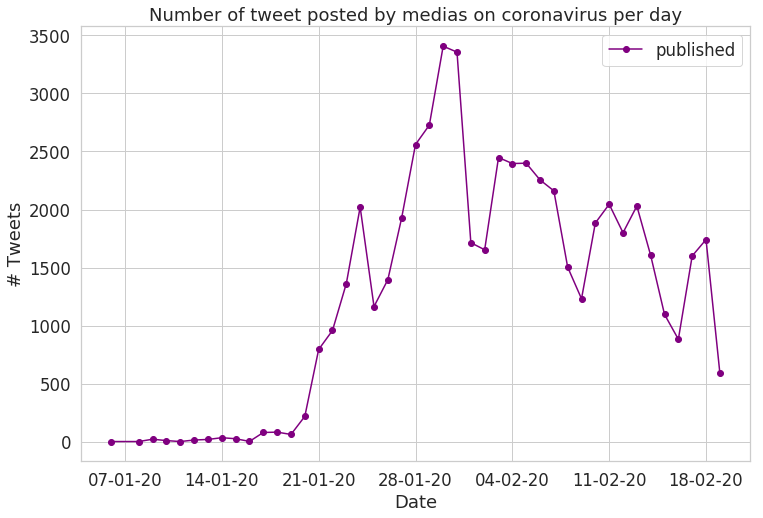

In [102]:
plotTweetPerDay(tweets_medias_per_day, "Number of tweet posted by medias on coronavirus per day", 1)

## Load or compute all tweets

In [94]:
PATH = "/mnt/datastore/data/coronavirus"

tweets_users_per_day = pd.DataFrame(columns=['published'])
medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)

all_files = list(os.listdir(PATH))

for i,f in enumerate(all_files):
    if(int(f.split(".")[0]) > 633):
        continue
    print('Loading files %d/%d : %s'%(i+1,len(all_files), f))
    temp = pd.read_json(os.path.join(PATH,f), orient="records")
    temp = temp[~temp['author_handle'].isin(medias_accounts[0])]
    temp['published'] = pd.to_datetime(temp['published'], infer_datetime_format=True) 
    temp = temp[['published']]
    tweets_users_per_day = pd.concat([tweets_users_per_day, temp])
    
print("Done!" + " "*30)

tweets_users_per_day = groupByDay(tweets_users_per_day, 'published')

tweets_users_per_day.to_csv("/mnt/datastore/data/tweets_per_day_users.csv", encoding='utf-8')

Loading files 1/634 : 94.json
Loading files 2/634 : 310.json
Loading files 3/634 : 123.json
Loading files 4/634 : 38.json
Loading files 5/634 : 221.json
Loading files 6/634 : 500.json
Loading files 7/634 : 560.json
Loading files 8/634 : 251.json
Loading files 9/634 : 575.json
Loading files 10/634 : 2.json
Loading files 11/634 : 524.json
Loading files 12/634 : 70.json
Loading files 13/634 : 138.json
Loading files 14/634 : 392.json
Loading files 15/634 : 286.json
Loading files 16/634 : 326.json
Loading files 17/634 : 329.json
Loading files 18/634 : 589.json
Loading files 19/634 : 365.json
Loading files 20/634 : 363.json
Loading files 21/634 : 478.json
Loading files 22/634 : 134.json
Loading files 23/634 : 54.json
Loading files 24/634 : 431.json
Loading files 25/634 : 125.json
Loading files 26/634 : 25.json
Loading files 27/634 : 579.json
Loading files 28/634 : 606.json
Loading files 29/634 : 137.json
Loading files 30/634 : 213.json
Loading files 31/634 : 367.json
Loading files 32/634 : 4

Loading files 254/634 : 285.json
Loading files 255/634 : 468.json
Loading files 256/634 : 95.json
Loading files 257/634 : 328.json
Loading files 258/634 : 35.json
Loading files 259/634 : 403.json
Loading files 260/634 : 8.json
Loading files 261/634 : 21.json
Loading files 262/634 : 20.json
Loading files 263/634 : 531.json
Loading files 264/634 : 629.json
Loading files 265/634 : 214.json
Loading files 266/634 : 424.json
Loading files 267/634 : 556.json
Loading files 268/634 : 407.json
Loading files 269/634 : 573.json
Loading files 270/634 : 360.json
Loading files 271/634 : 53.json
Loading files 272/634 : 24.json
Loading files 273/634 : 617.json
Loading files 274/634 : 547.json
Loading files 275/634 : 591.json
Loading files 276/634 : 359.json
Loading files 277/634 : 85.json
Loading files 278/634 : 10.json
Loading files 279/634 : 114.json
Loading files 280/634 : 490.json
Loading files 281/634 : 557.json
Loading files 282/634 : 507.json
Loading files 283/634 : 236.json
Loading files 284/63

Loading files 504/634 : 252.json
Loading files 505/634 : 23.json
Loading files 506/634 : 226.json
Loading files 507/634 : 178.json
Loading files 508/634 : 607.json
Loading files 509/634 : 331.json
Loading files 510/634 : 15.json
Loading files 511/634 : 207.json
Loading files 512/634 : 229.json
Loading files 513/634 : 319.json
Loading files 514/634 : 526.json
Loading files 515/634 : 627.json
Loading files 516/634 : 442.json
Loading files 517/634 : 193.json
Loading files 518/634 : 512.json
Loading files 519/634 : 476.json
Loading files 520/634 : 596.json
Loading files 521/634 : 480.json
Loading files 522/634 : 370.json
Loading files 523/634 : 538.json
Loading files 524/634 : 136.json
Loading files 525/634 : 567.json
Loading files 526/634 : 453.json
Loading files 527/634 : 316.json
Loading files 528/634 : 287.json
Loading files 529/634 : 472.json
Loading files 530/634 : 633.json
Loading files 531/634 : 154.json
Loading files 532/634 : 173.json
Loading files 533/634 : 334.json
Loading file

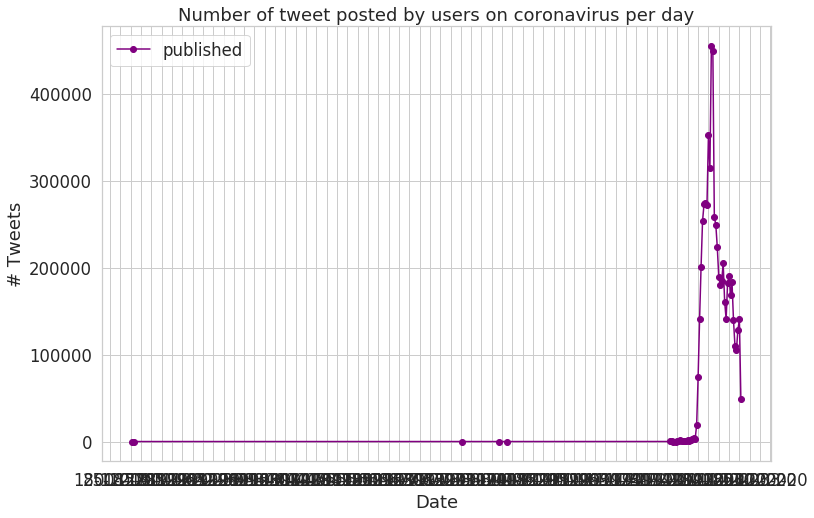

In [111]:
tweets_users_per_day = pd.read_csv("/mnt/datastore/data/tweets_per_day_users.csv")
tweets_users_per_day['date'] = pd.to_datetime(tweets_users_per_day['date'], infer_datetime_format=True) 
plotTweetPerDay(tweets_users_per_day, "Number of tweet posted by users on coronavirus per day", 1)

## Putting everything together

In [112]:
merge = tweets_medias_per_day.merge(tweets_users_per_day, left_on='date', right_on='date', how='inner').fillna(0)

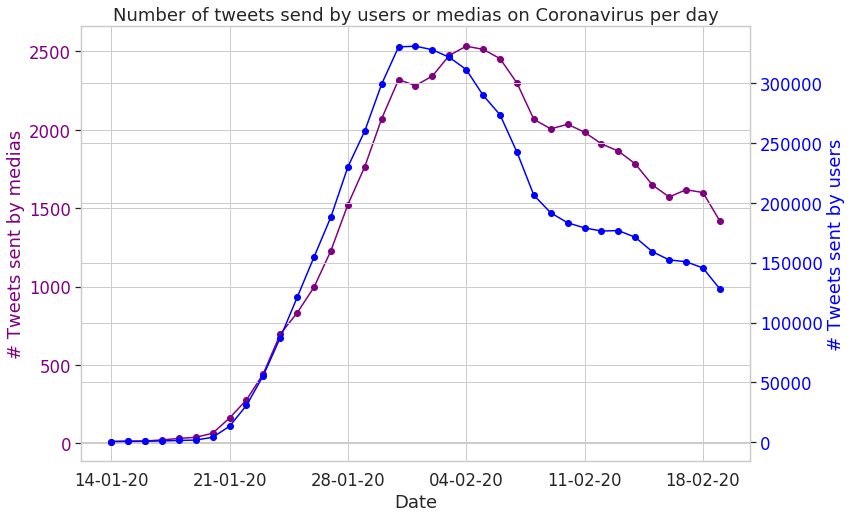

In [124]:
merge = merge.sort_values(by=['date'])
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(merge['date'],
        merge['published_x'].rolling(window=8).mean(),
        '-o',
        color='purple', label="medias")
ax.set_ylabel('# Tweets sent by medias', color='purple')
ax.tick_params(axis='y', labelcolor='purple')
ax.set(xlabel="Date",
       title="Number of tweets send by users or medias on Coronavirus per day")

ax2 = ax.twinx()
ax2.plot(merge['date'],
        merge['published_y'].rolling(window=8).mean(),
        '-o',
        color='blue', label="users")
ax2.set_ylabel('# Tweets sent by users', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
#plt.legend()
plt.show()